In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob
import statistics
import statsmodels.api as sm
import statsmodels.stats.api as stats
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder

# import train-test split
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score

# 'metrics' from sklearn is used for evaluating the model performance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import various functions from scipy
import scipy as sci
from scipy import stats as scistats
from scipy.stats import shapiro


#**⛳Load the dataset**

In [7]:
#load all the csv files from path, here I collect them into one csv file for convenience
filePath = '/content/drive/MyDrive/Colab Notebooks/Materials/Beijing_PM2.5_varriation'
allFiles = glob.glob(filePath + "/*.csv")
dataFrames = []
for i in allFiles:
    df = pd.read_csv(i, index_col=None, header=0)
    dataFrames.append(df)
df = pd.concat(dataFrames)
df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,27.0,4.0,20.0,300.0,81.0,12.6,1011.9,-14.3,0.0,N,2.0,Wanliu
35060,35061,2017,2,28,20,15.0,43.0,6.0,55.0,500.0,45.0,9.4,1012.3,-11.9,0.0,WSW,1.0,Wanliu
35061,35062,2017,2,28,21,13.0,35.0,7.0,48.0,500.0,48.0,8.7,1012.8,-13.7,0.0,N,1.1,Wanliu
35062,35063,2017,2,28,22,12.0,31.0,5.0,47.0,500.0,50.0,7.8,1012.9,-12.6,0.0,NNE,1.0,Wanliu


In [ ]:
import datetime

df['date'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day']), axis=1)
df.drop(columns=['No'], inplace=True)

In [ ]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,date
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01


Acknowledgements

Zhang, S., Guo, B., Dong, A., He, J., Xu, Z. and Chen, S.X. (2017) Cautionary Tales on Air-Quality Improvement in Beijing. Proceedings of the Royal Society A, Volume 473, No. 2205, Pages 20170457.

The files were downloaded from the UCI Machine Learning Repository and have not been modified.
https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

# 📝**Exploratory analysis of data**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420768 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   year     420768 non-null  int64         
 1   month    420768 non-null  int64         
 2   day      420768 non-null  int64         
 3   hour     420768 non-null  int64         
 4   PM2.5    412029 non-null  float64       
 5   PM10     414319 non-null  float64       
 6   SO2      411747 non-null  float64       
 7   NO2      408652 non-null  float64       
 8   CO       400067 non-null  float64       
 9   O3       407491 non-null  float64       
 10  TEMP     420370 non-null  float64       
 11  PRES     420375 non-null  float64       
 12  DEWP     420365 non-null  float64       
 13  RAIN     420378 non-null  float64       
 14  wd       418946 non-null  object        
 15  WSPM     420450 non-null  float64       
 16  station  420768 non-null  object        
 17  date     42

##**Data cleaning**

In [ ]:
df.isna().sum().sum()

74027

In [ ]:
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data

,Missing Ratio
CO,4.919813
O3,3.155421
NO2,2.879497
SO2,2.143937
PM2.5,2.076916
PM10,1.532674
wd,0.433018
DEWP,0.095777
TEMP,0.094589
PRES,0.093401


Text(0.5, 1.0, 'Figure 2. Percent missing data by feature')

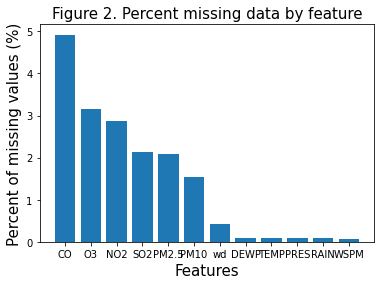

In [ ]:
plt.bar(df_na.index, df_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values (%)', fontsize=15)
plt.title('Figure 2. Percent missing data by feature', fontsize=15)

In [ ]:
# impute missing values
df['PM2.5'].fillna(df['PM2.5'].median(), inplace=True)
df['PM10'].fillna(df['PM10'].median(), inplace=True)
df['SO2'].fillna(df['SO2'].median(), inplace=True)
df['NO2'].fillna(df['NO2'].median(), inplace=True)
df['CO'].fillna(df['CO'].median(), inplace=True)
df['O3'].fillna(df['O3'].median(), inplace=True)
df['TEMP'].fillna(df['TEMP'].median(), inplace=True)
df['PRES'].fillna(df['PRES'].median(), inplace=True)
df['DEWP'].fillna(df['DEWP'].median(), inplace=True)
df['RAIN'].fillna(df['RAIN'].median(), inplace=True)
df['WSPM'].fillna(df['WSPM'].median(), inplace=True)

## **Summary Statistics**

In [ ]:
df.drop(['year','month','day','hour'],axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM2.5,420768.0,79.278489,80.056799,2.0000,21.0,55.0,109.0,999.0
PM10,420768.0,104.256193,91.108745,2.0000,36.0,82.0,144.0,999.0
SO2,420768.0,15.641507,21.455419,0.2856,3.0,7.0,19.0,500.0
NO2,420768.0,50.418633,34.642023,1.0265,24.0,43.0,70.0,290.0
CO,420768.0,1214.493362,1133.542988,100.0000,500.0,900.0,1500.0,10000.0
O3,420768.0,56.981874,55.802413,0.2142,12.0,45.0,80.0,1071.0
TEMP,420768.0,13.539885,11.430768,-19.9000,3.1,14.5,23.2,41.6
PRES,420768.0,1010.746658,10.469168,982.4000,1002.3,1010.4,1019.0,1042.8
DEWP,420768.0,2.491405,13.787252,-43.4000,-8.9,3.1,15.1,29.1
RAIN,420768.0,0.064416,0.820626,0.0000,0.0,0.0,0.0,72.5


##**Outlier** **Analysis**

In [ ]:
data = df.drop(['year','month','day','hour'],axis=1).copy()
data = data.select_dtypes(exclude='object')

plt.figure(figsize = (15,5))
data.boxplot()
plt.title('Distribution of all Numeric Variables', fontsize = 15)
plt.xticks(fontsize = 10)

plt.show()

NameError: ignored

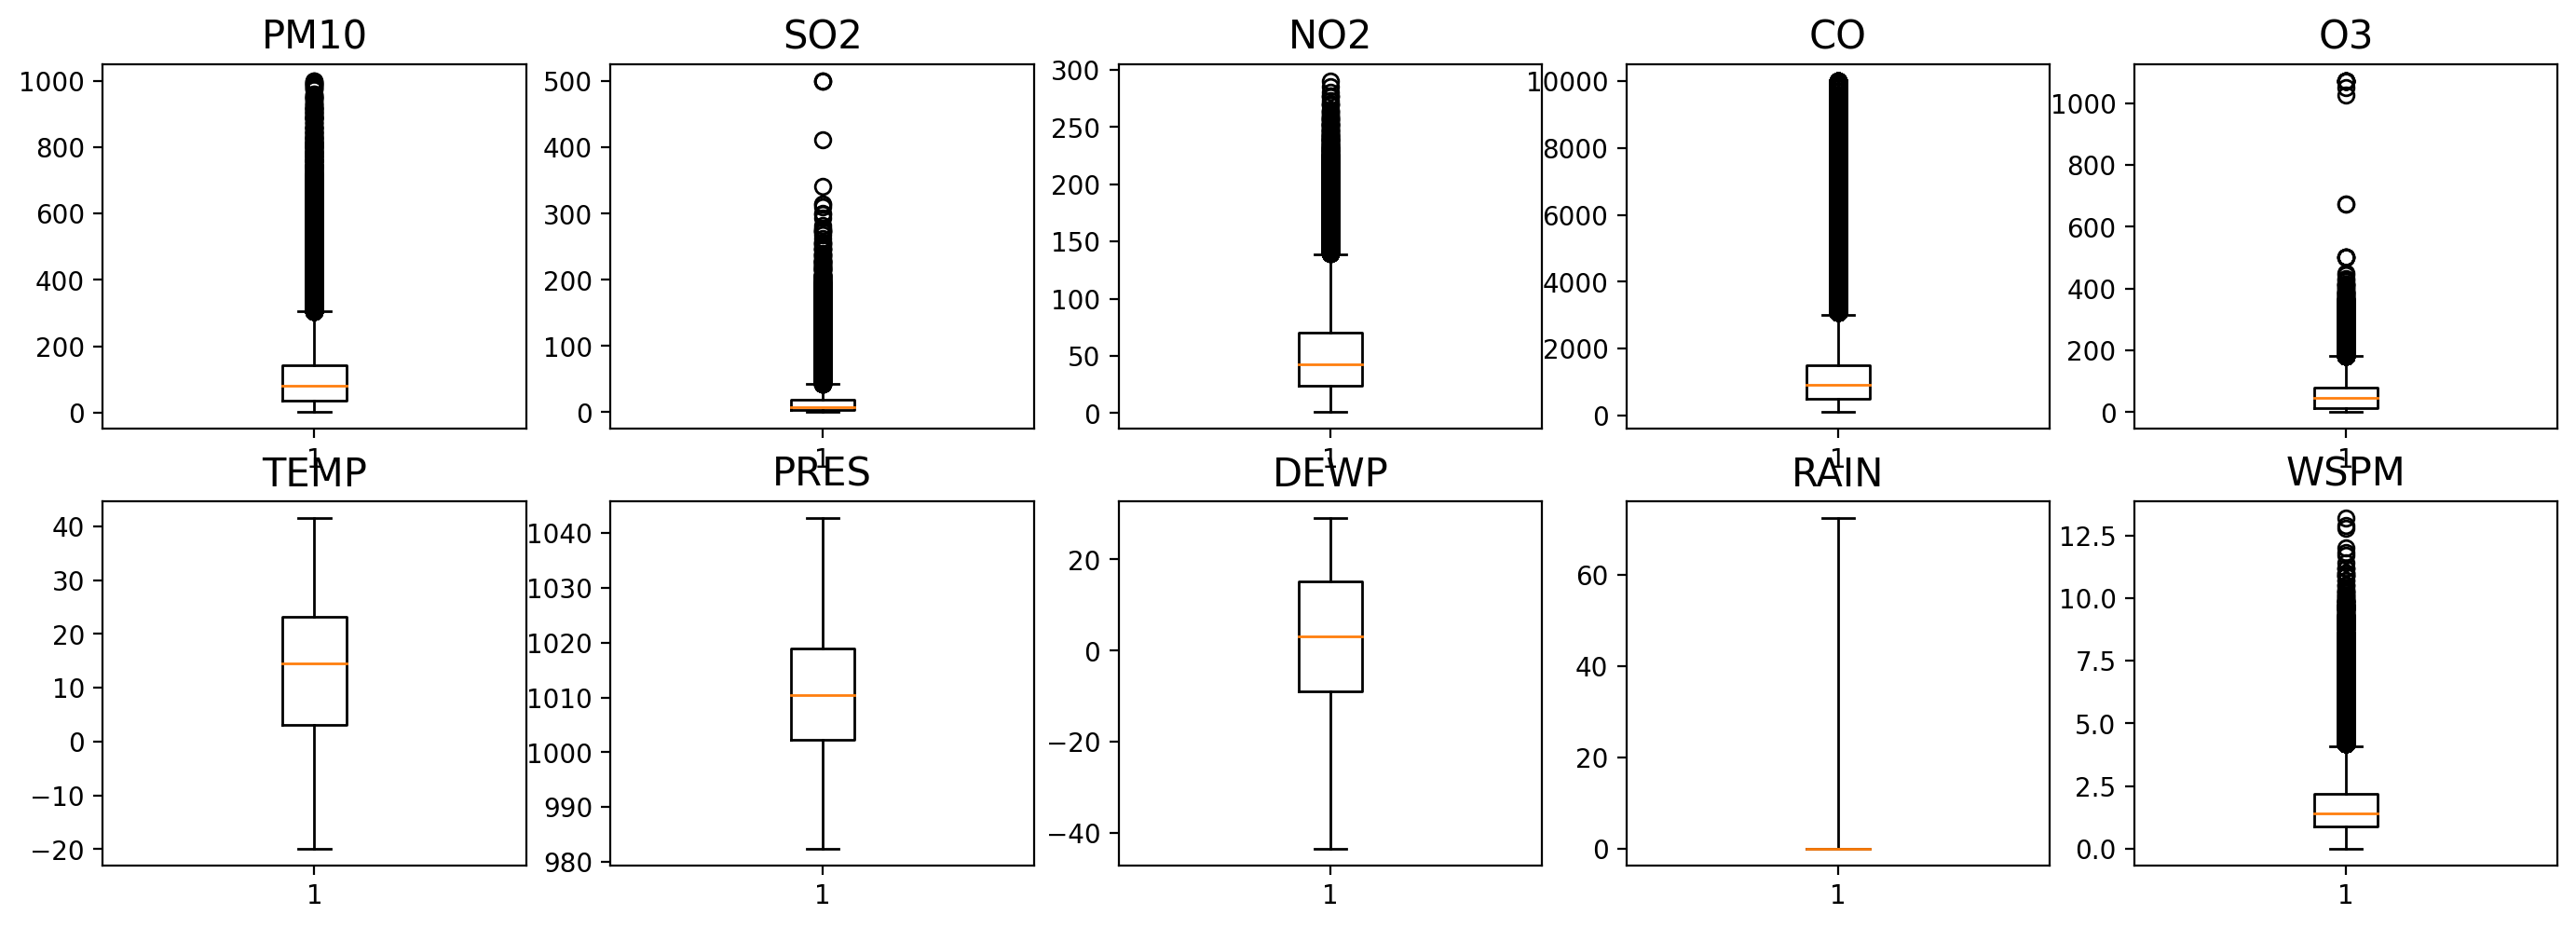

In [ ]:
data = df.select_dtypes(exclude='object').copy()
data.drop(['month','day','year','hour','date'],axis=1, inplace=True)
outliers_by_variables = data.drop(['PM2.5'],axis=1).columns

plt.figure(figsize=(17,15), dpi=200)
for i in range(0,outliers_by_variables.shape[0]):
    plt.subplot(5,5, i+1)
    plt.boxplot(data[outliers_by_variables[i]], autorange=True)
    plt.title(outliers_by_variables[i], fontdict= {'fontsize': 15 ,'fontweight': 5, 'color':'000000'})
    plt.AutoLocator.default_params

**Outlier analysis for Target Variable**

Skewness of the Target Variable:  2.0479


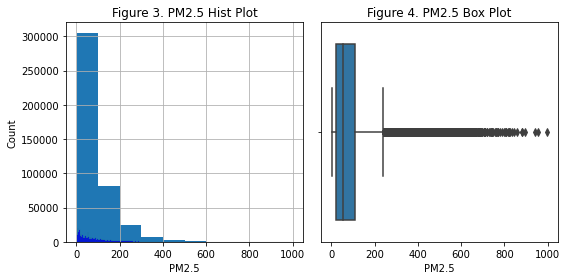

In [ ]:
print("Skewness of the Target Variable: ", round(df['PM2.5'].skew(),4))
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (8,4))
df['PM2.5'].hist(ax = axes[0])
sns.histplot(df['PM2.5'], ax = axes[0], color='b')
axes[0].set_title('Figure 3. PM2.5 Hist Plot', fontsize = 12)

# plot the Q-Q plot
sns.boxplot(df['PM2.5'], ax = axes[1],orient="v")
axes[1].set_title('Figure 4. PM2.5 Box Plot', fontsize = 12)
fig.tight_layout()
plt.show()

Skewness of the Target Variable:  -0.4083


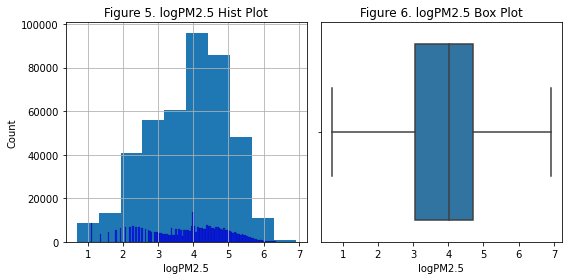

In [ ]:
df['logPM2.5'] = np.log(df['PM2.5'])
print("Skewness of the Target Variable: ", round(df['logPM2.5'].skew(),4))
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (8,4))
df['logPM2.5'].hist(ax = axes[0])
sns.histplot(df['logPM2.5'], ax = axes[0], color='b')
axes[0].set_title('Figure 5. logPM2.5 Hist Plot', fontsize = 12)

# plot the Q-Q plot
sns.boxplot(df['logPM2.5'], ax = axes[1],orient="v")
axes[1].set_title('Figure 6. logPM2.5 Box Plot', fontsize = 12)
fig.tight_layout()
plt.show()

- Interpretation: extreme values are either above the upper limit or below lower limit. However, the exact location of these points is not precisely seen.

- 2.0479 > 0 implies positive skewnesss
Target Variable is Poistively Skewed

##**Correlation plot**

[Text(0.5, 1.0, 'Figure 7. Correlation matrix between variables')]

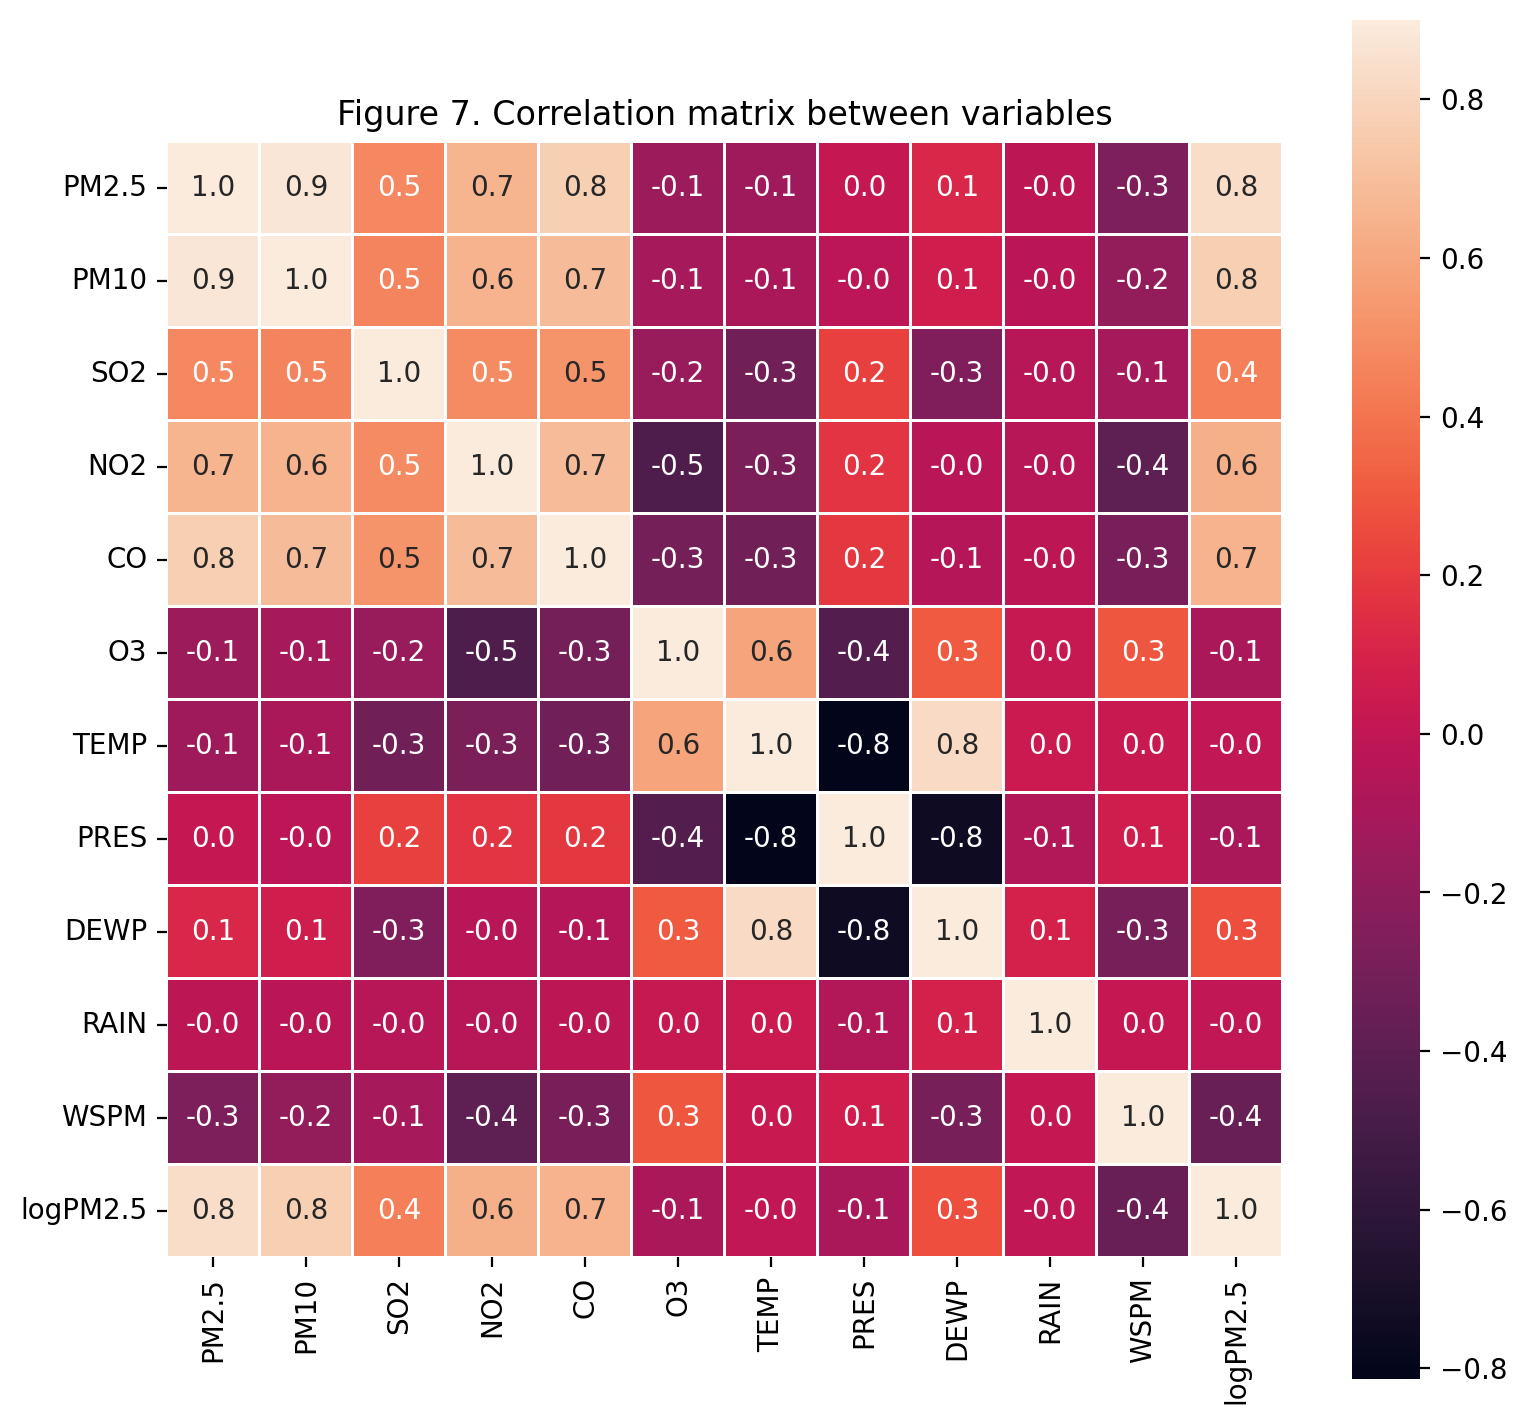

In [ ]:
plt.figure(figsize=(9,9),dpi=200)
df_corr = df.drop(['year','month','day','hour','day'],axis=1).corr()
sns.heatmap(df_corr, vmax=0.9, square=True, annot=True, linewidths=.5, fmt= '.1f').set(title='Figure 7. Correlation matrix between variables')

Interpretation: Relatively high correlation seen among CO, NO2, SO2 and PM2.5 and also between O3 and temp.
Subsequent models might have high Multicolinearity behavior

##**Outlier Treatment using IQR**

In [ ]:
print('Before: Outliers Treating with IQR', data.shape)
data['logPM2.5'] = df['logPM2.5']
df_outlier = data.copy()
df_outlier  = df_outlier.select_dtypes(exclude ='object')
q1 = df_outlier.quantile(0.25)
q3 = df_outlier.quantile(0.75)
iqr = q3-q1

df_outlier = df_outlier[~((df_outlier  < (q1-(1.5*iqr))) | (df_outlier  > (q3+(1.5*iqr)))).any(axis=1)]
print('After: Outliers Treating with IQR', df_outlier.shape)

Before: Outliers Treating with IQR (420768, 11)
After: Outliers Treating with IQR (303094, 12)


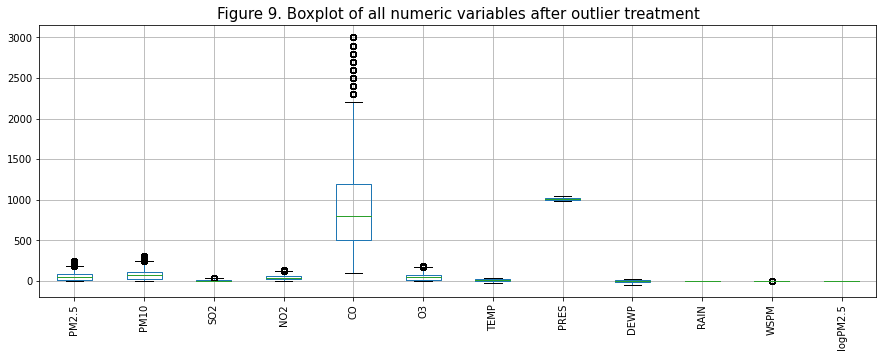

In [ ]:
df_outlier = df_outlier.select_dtypes(exclude='object').copy()
plt.figure(figsize = (15,5))
df_outlier.boxplot()
plt.title('Figure 9. Boxplot of all numeric variables after outlier treatment', fontsize = 15)
plt.xticks(rotation = 'vertical', fontsize = 10)
plt.show()

## **Categorical Variable Analysis**

[Text(0.5, 1.0, 'Figure 10. Boxplot of the PM2.5 by wind direction')]

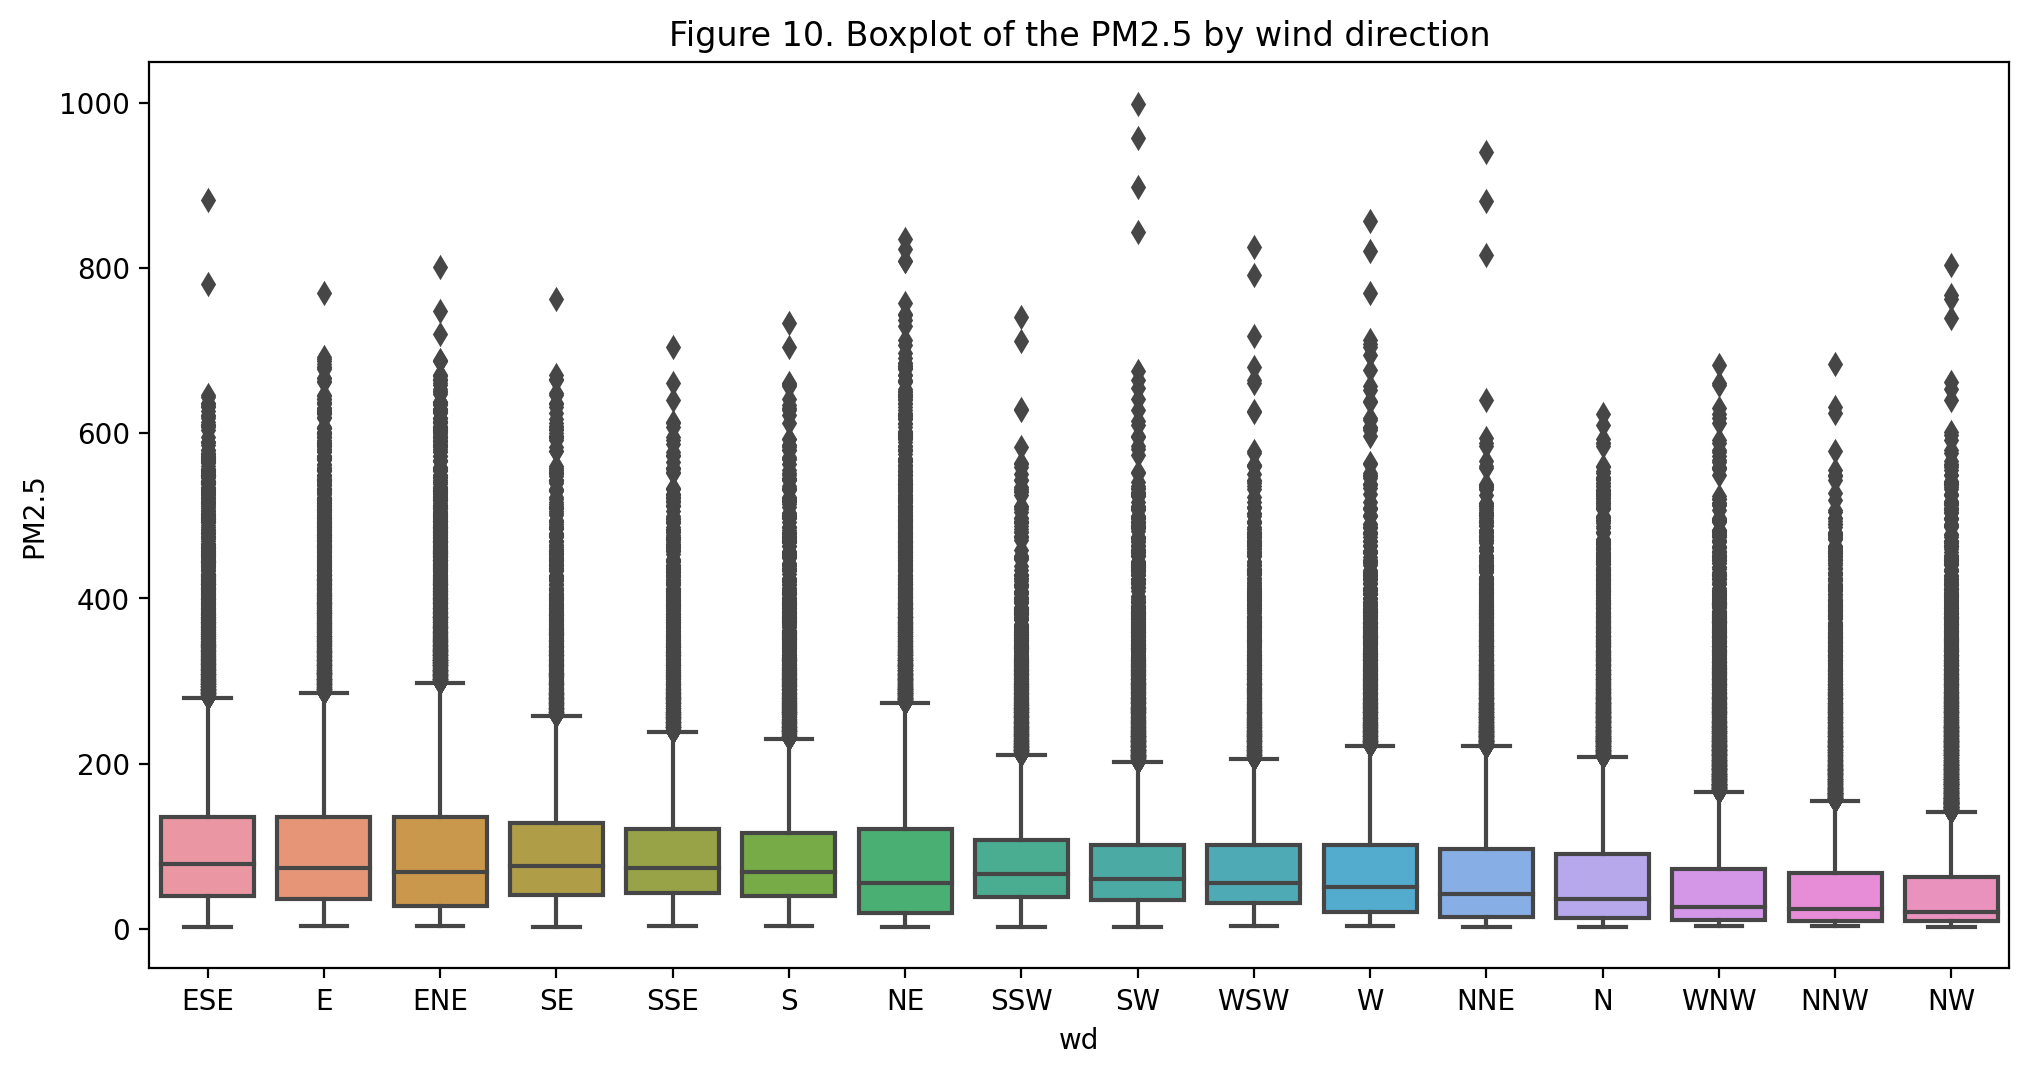

In [ ]:
plt.figure(figsize=(12,6),dpi=200)

group = df.groupby(by='wd')
group['PM2.5'].mean()
sorted_index = group['PM2.5'].mean().sort_values(ascending=False).index
sns.boxplot(df['wd'],df['PM2.5'],order = sorted_index).set(title='Figure 10. Boxplot of the PM2.5 by wind direction')

[Text(0.5, 1.0, 'Figure 11. Boxplot of the PM2.5 by station')]

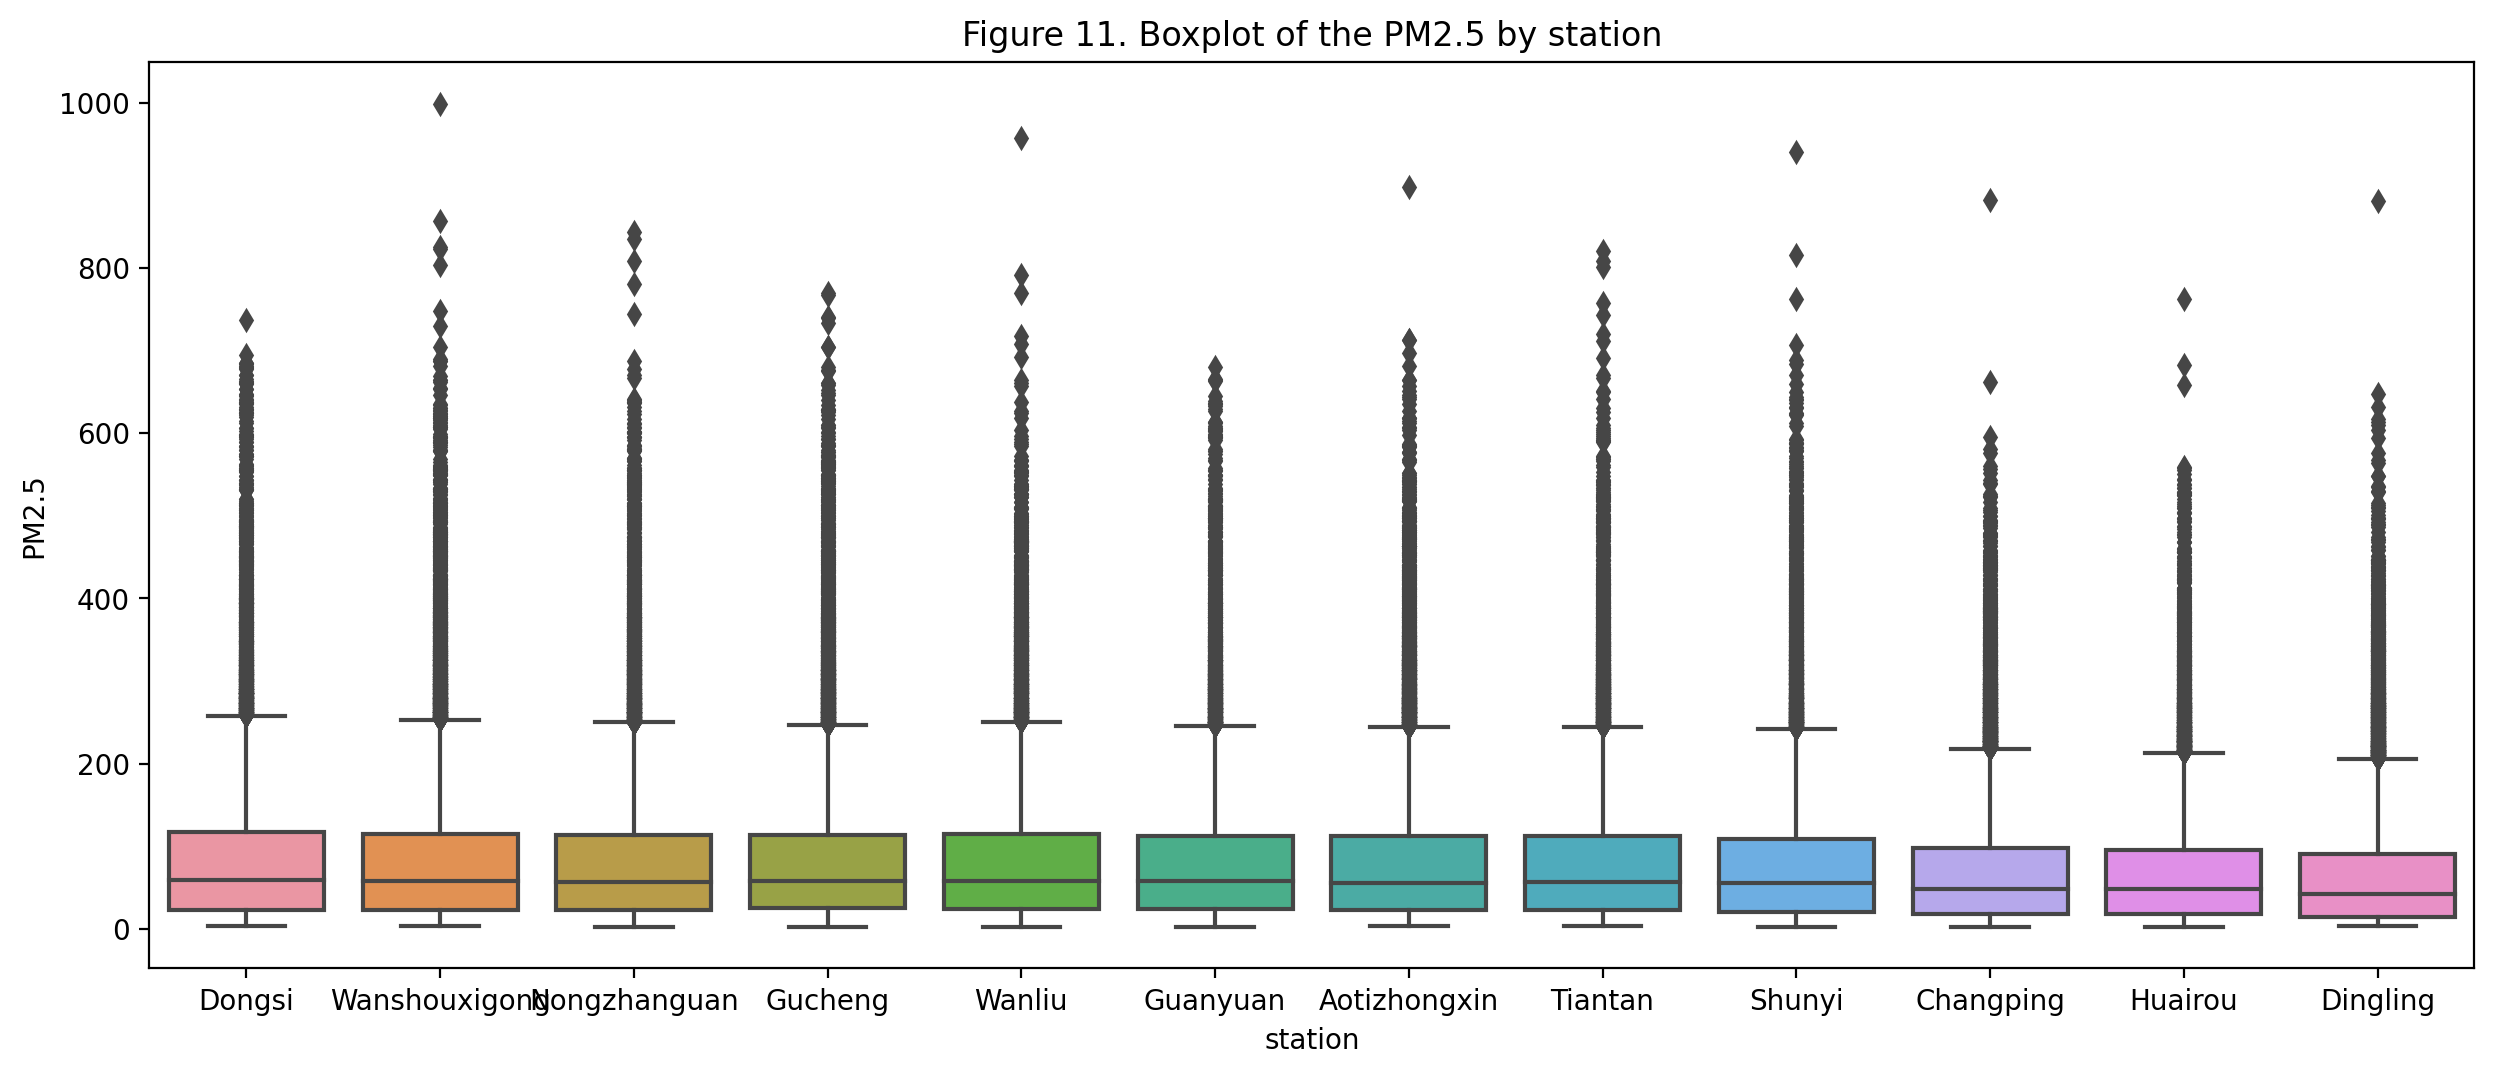

In [ ]:
plt.figure(figsize=(15,6),dpi=200)

group = df.groupby(by='station')
group['PM2.5'].mean()
sorted_index = group['PM2.5'].mean().sort_values(ascending=False).index
sns.boxplot(df['station'],df['PM2.5'],order = sorted_index).set(title='Figure 11. Boxplot of the PM2.5 by station')

# **📊Time series plot**

##**Yearly Analysis of Pollutants for each Station**

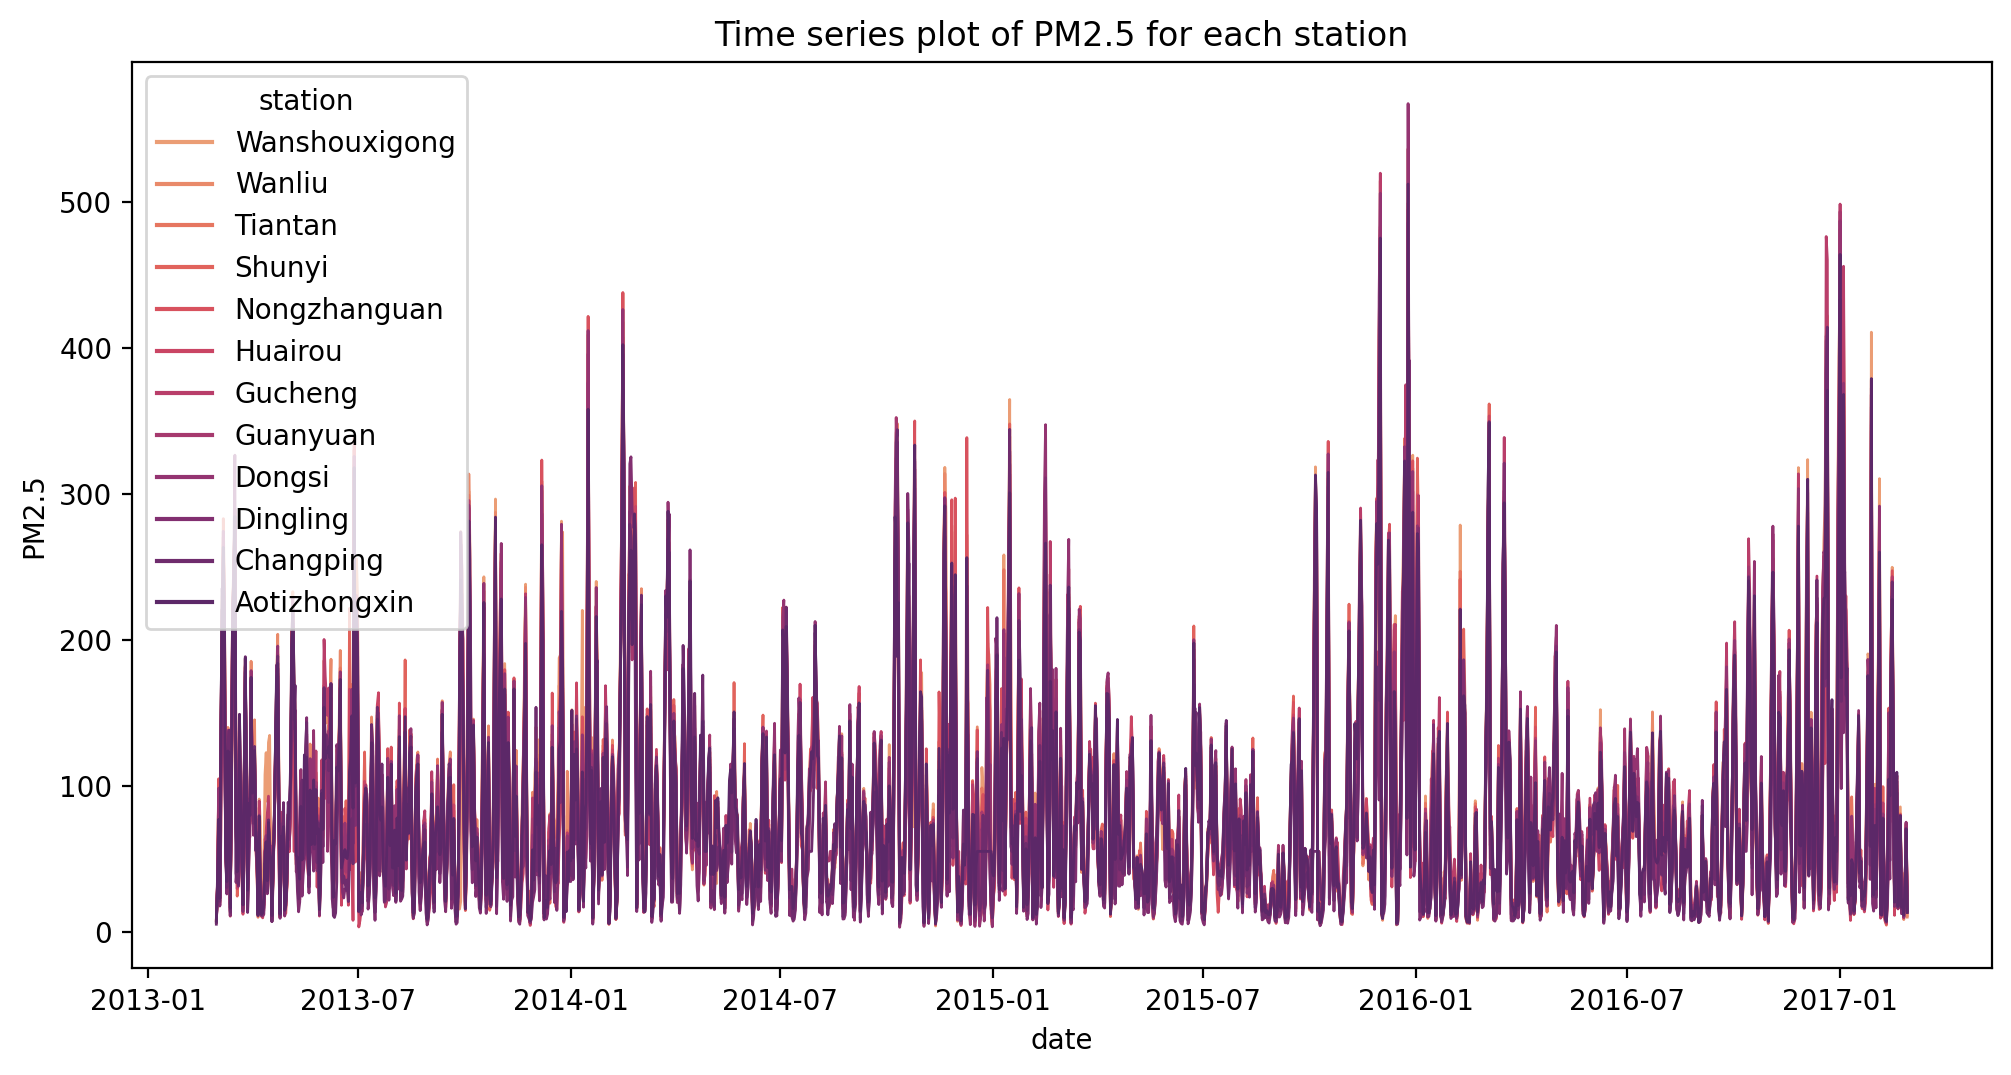

In [ ]:
f, ax=plt.subplots(figsize=(12,6),dpi=200)
df_year = df[['PM2.5','station','year','date']].groupby(["date",'station']).mean().reset_index().sort_values(by=['date','station'], ascending=False)
plt.title('Time series plot of PM2.5 for each station')
sns.lineplot(x='date', y='PM2.5', hue='station', data=df_year, palette = "flare",linewidth=1)

plt.show()

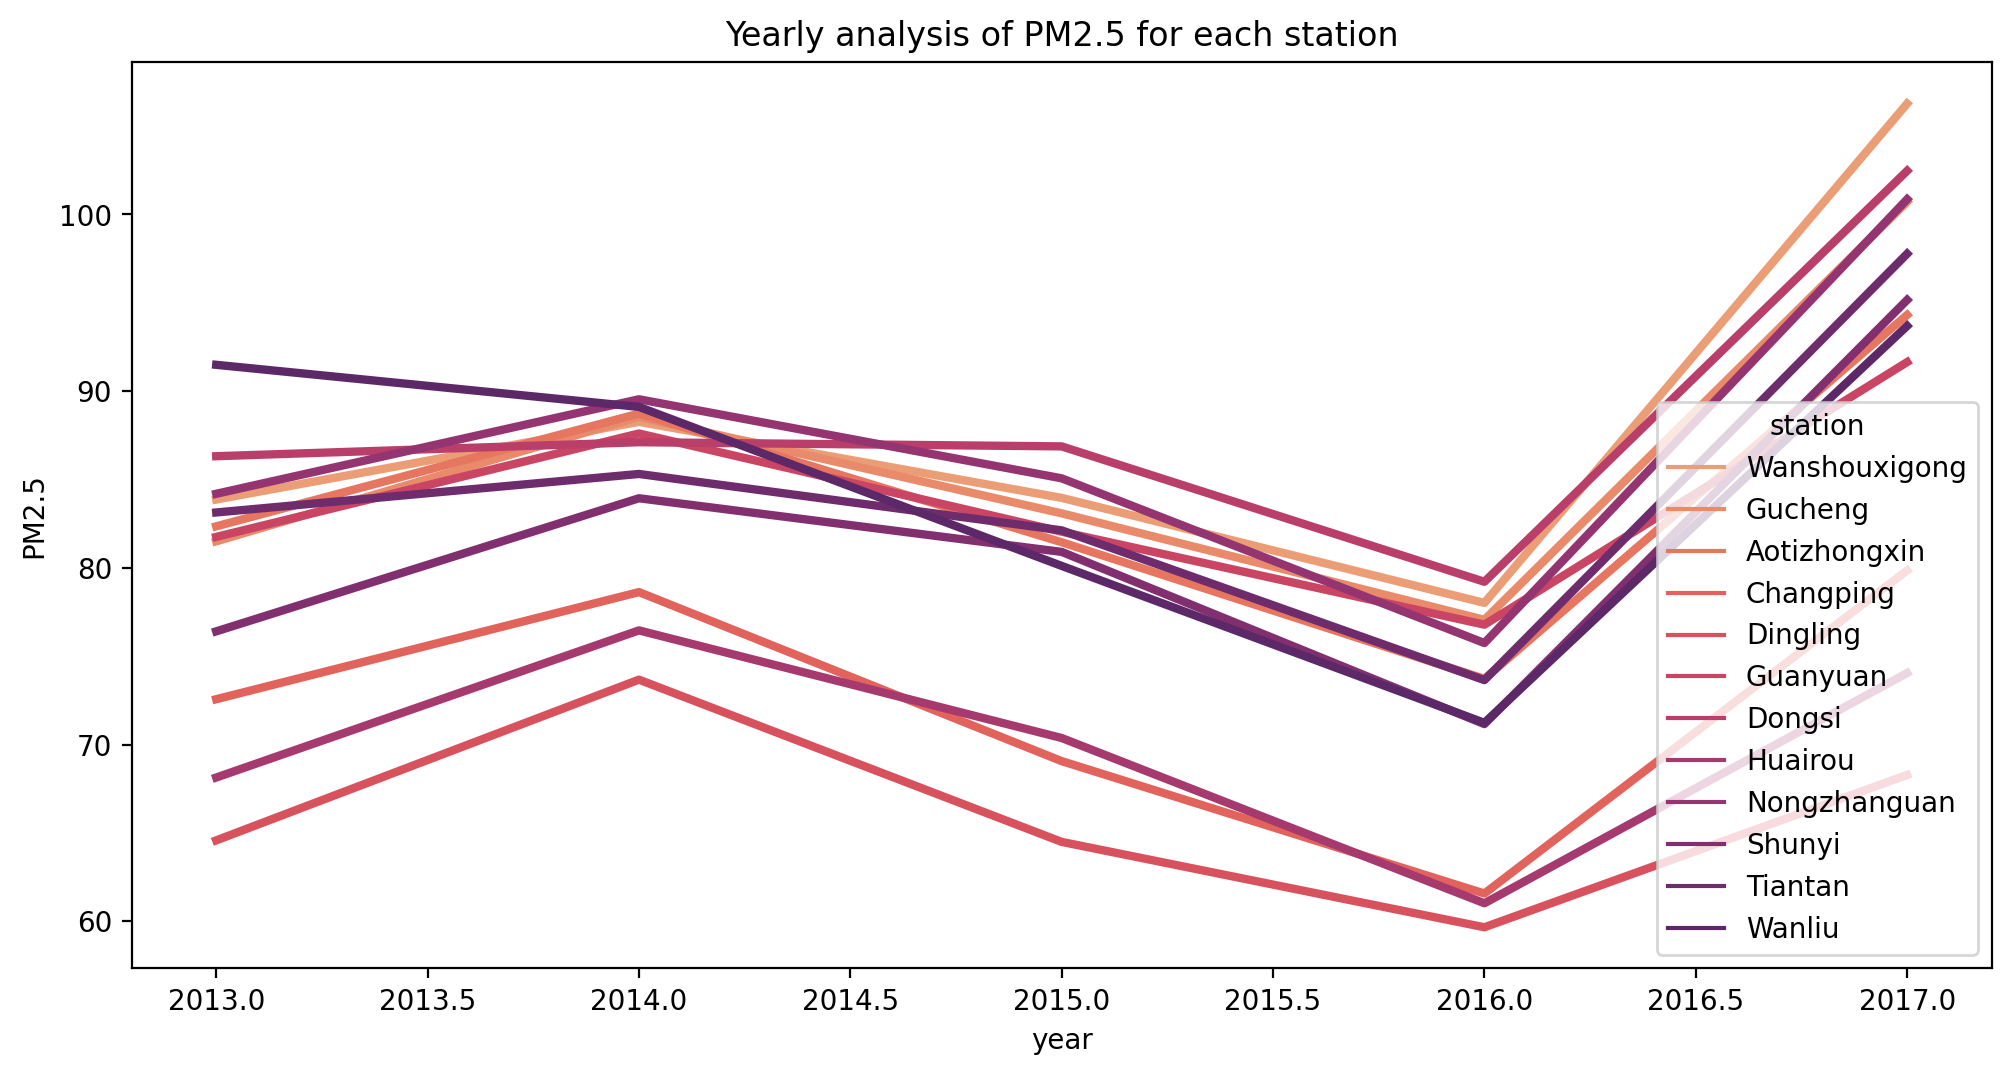

In [ ]:
df_year = df[['PM2.5', 'year','station']].groupby(["year",'station']).mean().reset_index().sort_values(by='year', ascending=False)
f, ax=plt.subplots(figsize=(12,6),dpi=200)
plt.title('Yearly analysis of PM2.5 for each station')
sns.lineplot(x='year', y='PM2.5', hue='station', data=df_year,palette = "flare",linewidth=3)
plt.show()

##**Month Analysis of Pollutants for each year**

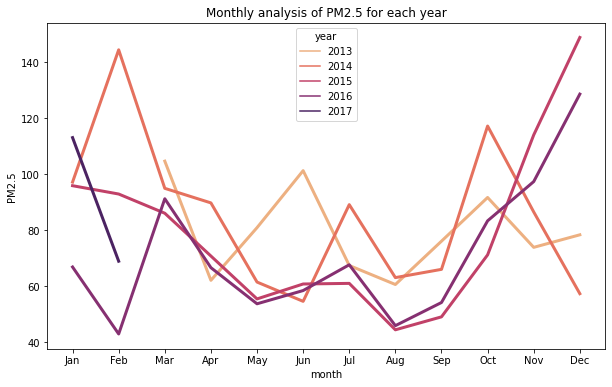

In [ ]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}

df_month = df.copy()
df_month.month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df_month = df_month[['PM2.5', 'month', 'year']].groupby(["year","month"]).mean().reset_index().sort_values(by=['year','month'], ascending=True)
df_month = df_month.iloc[df_month['month'].map(custom_dict).argsort()]
f, ax=plt.subplots(figsize=(10, 6))
sns.lineplot(x='month', y='PM2.5', data=df_month, hue="year",palette = "flare",linewidth=3)
plt.title('Monthly analysis of PM2.5 for each year')
plt.show()

##**Hourly Analysis of Pollutants for each year**

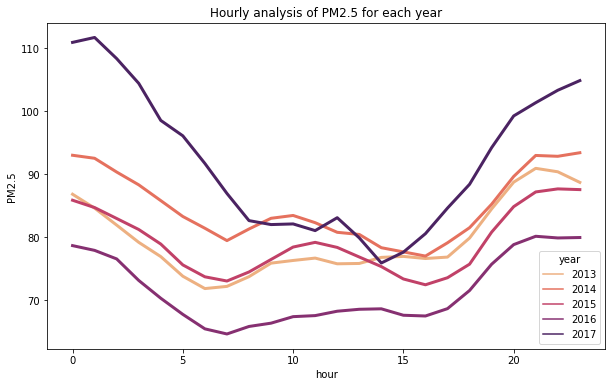

In [ ]:
df_hour = df[['PM2.5', 'hour', 'year']].groupby(["year","hour"]).mean().reset_index().sort_values(by=['year','hour'], ascending=False)
f,ax=plt.subplots(figsize=(10,6))
sns.lineplot(x='hour', y='PM2.5', data=df_hour, hue="year", palette = "flare",linewidth=3)
plt.title('Hourly analysis of PM2.5 for each year')
plt.show()

#📈**Model Building and Analysis**

##**VIF**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_comp_num = data.select_dtypes(exclude = 'object')

df_comp_vif  = pd.DataFrame()
df_comp_vif['columns'] = df_comp_num.columns
df_comp_vif['VIF_Value'] = [variance_inflation_factor(df_comp_num.values, i) for i in range(df_comp_num.shape[1])]
df_comp_vif.sort_values('VIF_Value', ascending=False)
# VIF > 10 has multicolinearity issue


,columns,VIF_Value
11,logPM2.5,54.567510
7,PRES,42.317102
6,TEMP,16.272682
0,PM2.5,14.713949
1,PM10,11.540356
3,NO2,9.613966
4,CO,6.872579
8,DEWP,6.620295
10,WSPM,4.829273
5,O3,4.585025


In [ ]:
df_md1 = df_comp_num.copy()

##**OLS regression**

In [ ]:
#Split the data into training and test sets.
X = df_md1.drop(['PRES','TEMP','RAIN','PM10','PM2.5','logPM2.5'], axis=1)
X = sm.add_constant(X)
Y = df_md1['logPM2.5']

X_train , X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(336614, 7) (84154, 7) (336614,) (84154,)


In [ ]:
X_train

,const,SO2,NO2,CO,O3,DEWP,WSPM
5391,1.0,13.0,72.0,500.0,83.0,3.5,0.7
10171,1.0,5.0,42.0,500.0,153.0,2.3,2.5
12232,1.0,2.0,22.0,400.0,125.0,18.8,1.1
11679,1.0,7.0,19.0,1200.0,335.0,18.8,2.3
21257,1.0,8.0,38.0,600.0,56.0,17.3,1.3
...,...,...,...,...,...,...,...
16181,1.0,45.0,83.0,2200.0,2.0,-15.4,1.7
32089,1.0,2.0,9.0,600.0,25.0,6.5,1.1
21191,1.0,2.0,13.0,700.0,43.0,22.4,1.3
6753,1.0,53.0,66.0,1900.0,1.0,-5.0,1.0


In [ ]:
X_train = X_train.select_dtypes(exclude = 'object')
ols_model1 = sm.OLS(y_train, X_train).fit()
ols_model1.summary()

#wls regression logistic model
#unsample model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPM2.5   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                 9.023e+04
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:34:14   Log-Likelihood:            -3.5635e+05
No. Observations:              336614   AIC:                         7.127e+05
Df Residuals:                  336607   BIC:                         7.128e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5581      0.004    653.664      0.000       2.550       2.566
SO2            0.0090   7.17e-05    124.986      0.000       0.009       0.009
NO2            0.0115   5.49e-05    208.929      0.000       0.011       0.012
CO             0.0004   1.53e-06    234.238      0.000       0.000       0.000
O3             0.0026   2.75e-05     94.933      0.000       0.003       0.003
DEWP           0.0236      0.000    220.841      0.000       0.023       0.024
WSPM          -0.0432      0.001    -37.165      0.000      -0.045      -0.041
==============================================================================
Omnibus:                    24498.909   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40942.375
Skew:                          -0.559   Prob(JB):                         0.00
Kurtosis:                       4.292   Cond. No.                     5.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpretation:
- R-squared value
- Durbin-Watson: Test is used to check the autocorrelation between the residuals.No autocorrelation
- JB test: check the normality of the residuals. not normally distributed
- Condition Number (CN): The Condition Number (CN) is used to check the multicollinearity.

  - If CN < 100: no multicollinearity<br>
  - If CN is between 100 and 1000: moderate multicollinearity<br>
  - If CN > 1000: severe multicollinearity
  

In [ ]:
y_train_predict=ols_model1.predict(X_train)
y_test_predict=ols_model1.predict(X_test)

#print('Coefficient of determination (R^2): %.3f' % r2_score(y_train, y_train_predict))
print('Mean squared error (MSE): %.3f'% mean_squared_error(y_train, y_train_predict))
print('Root mean squared error (RMSE) : %.3f'% np.sqrt(mean_squared_error(y_train, y_train_predict)))


Mean squared error (MSE): 0.486
Root mean squared error (RMSE) : 0.697


**Linearity**

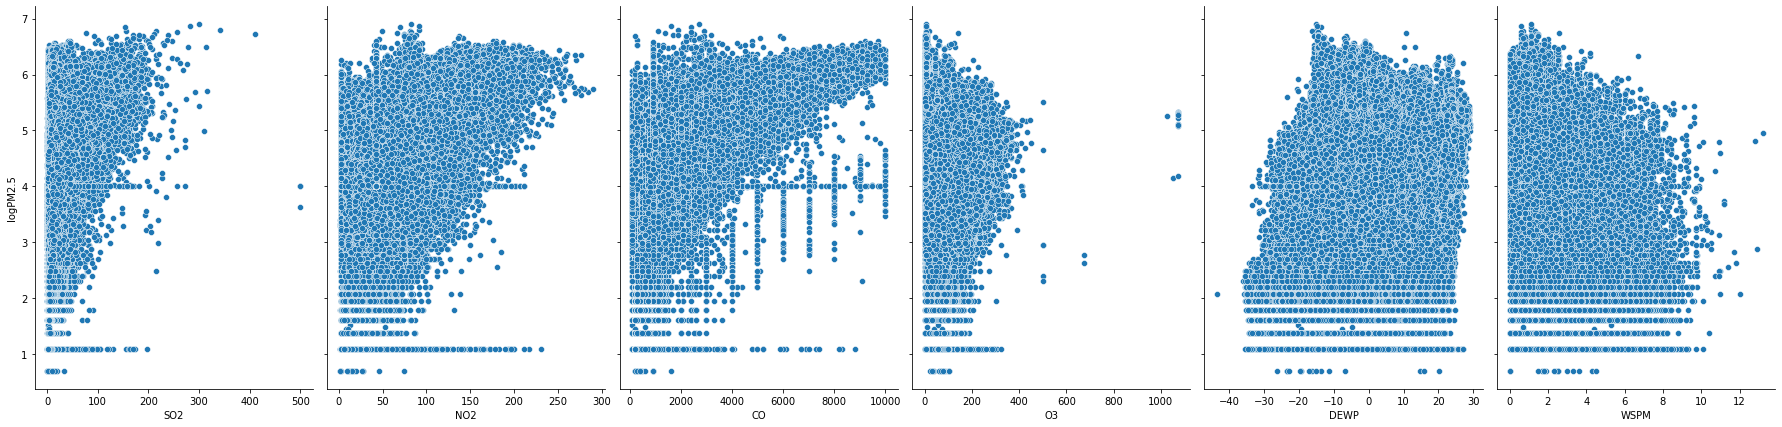

In [ ]:
p = sns.pairplot(df_md1, x_vars=['SO2','NO2','CO','O3','DEWP','WSPM'], y_vars='logPM2.5', size=6, aspect=0.7)

**Homoskedasticity**

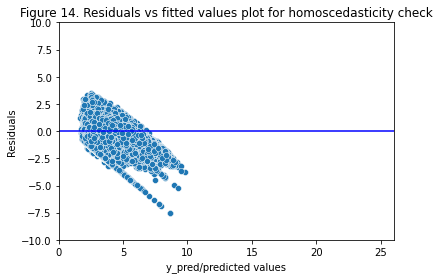

In [ ]:
p = sns.scatterplot(y_train_predict,ols_model1.resid)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Figure 14. Residuals vs fitted values plot for homoscedasticity check')

**Tests for Normality**

Skewness of the residuals:  -0.5692


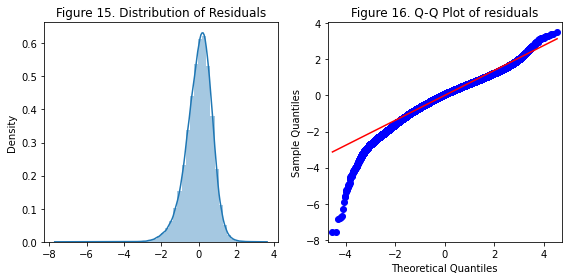

In [ ]:
# Plot Residual Error using SNS and QQ Plot for analysis
print("Skewness of the residuals: ", round(ols_model1.resid.skew(), 4) )
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (8,4))
# plot a distplot for the residuals
sns.distplot(ols_model1.resid, ax = axes[0])
# set text size using 'fontsize'
axes[0].set_title('Figure 15. Distribution of Residuals', fontsize = 12)

# plot the Q-Q plot
# 'r' represents the regression line
qqplot(ols_model1.resid, line = 'r', ax = axes[1])
axes[1].set_title('Figure 16. Q-Q Plot of residuals', fontsize = 12)
fig.tight_layout()
# display the plot
plt.show()

Interpretation: the distribution of the residuals is negatively skewed.

**Kolmogorov-Smirnov(Kolmogorov-Smirnov) test**

should only be used for large sample numbers (>300)

Ho: Residuals are normally distributed

H1: Residuals are not normally distributed

In [ ]:
import scipy.stats as stats
stat, p_value = stats.kstest(ols_model1.resid, 'norm')
print ('The z_score =', format(stat, '.2f')) #format printing of a floating point number
print('The p_value =', format(p_value, '.6f'))
if p_value >= 0.05:
  print('Data is normally distributed')
elif p_value < .05:
  print('Data is not normally distributed', '')

The z_score = 0.11
The p_value = 0.000000
Data is not normally distributed 


Interpretation: From the above test we can see that the p-value is 0.0 (less than 0.05), thus we can say that the residuals are not normally distributed.

## After outlier treatment

In [ ]:
df_outlier

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,logPM2.5
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,1.791759
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,1.098612
5,5.0,5.0,18.0,18.0,400.0,66.0,-2.2,1025.6,-19.6,0.0,3.7,1.609438
6,3.0,3.0,18.0,32.0,500.0,50.0,-2.6,1026.5,-19.1,0.0,2.5,1.098612
7,3.0,6.0,19.0,41.0,500.0,43.0,-1.6,1027.4,-19.1,0.0,3.8,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,11.0,27.0,4.0,20.0,300.0,81.0,12.6,1011.9,-14.3,0.0,2.0,2.397895
35060,15.0,43.0,6.0,55.0,500.0,45.0,9.4,1012.3,-11.9,0.0,1.0,2.708050
35061,13.0,35.0,7.0,48.0,500.0,48.0,8.7,1012.8,-13.7,0.0,1.1,2.564949
35062,12.0,31.0,5.0,47.0,500.0,50.0,7.8,1012.9,-12.6,0.0,1.0,2.484907


In [ ]:
X = df_outlier.copy()
X = sm.add_constant(X)
Y = df_outlier['logPM2.5']
X.drop(['PM2.5','logPM2.5', 'PRES', 'TEMP', 'RAIN','PM10'], axis =1,inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X,Y, train_size=0.2)

ols_model_exout=sm.OLS(y_train, X_train).fit()
# np.asarray(y_train)
ols_model_exout.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPM2.5   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                 1.708e+04
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:35:24   Log-Likelihood:                -57676.
No. Observations:               60618   AIC:                         1.154e+05
Df Residuals:                   60611   BIC:                         1.154e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0898      0.010    213.048      0.000       2.071       2.109
SO2            0.0165      0.000     49.283      0.000       0.016       0.017
NO2            0.0090      0.000     67.806      0.000       0.009       0.009
CO             0.0009   5.87e-06    145.200      0.000       0.001       0.001
O3             0.0031   7.62e-05     40.369      0.000       0.003       0.003
DEWP           0.0224      0.000     97.803      0.000       0.022       0.023
WSPM          -0.0224      0.003     -6.881      0.000      -0.029      -0.016
==============================================================================
Omnibus:                     3460.894   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5742.583
Skew:                          -0.465   Prob(JB):                         0.00
Kurtosis:                       4.187   Cond. No.                     4.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
y_train_predict = ols_model_exout.predict(X_train)
y_test_predict = ols_model_exout.predict(X_test)

#print('Coefficient of determination (R^2): %.3f' % r2_score(y_train, y_train_predict))
print('Mean squared error (MSE): %.3f'% mean_squared_error(y_train, y_train_predict))
print('Root mean squared error (RMSE) : %.3f'% np.sqrt(mean_squared_error(y_train, y_train_predict)))

Mean squared error (MSE): 0.393
Root mean squared error (RMSE) : 0.627


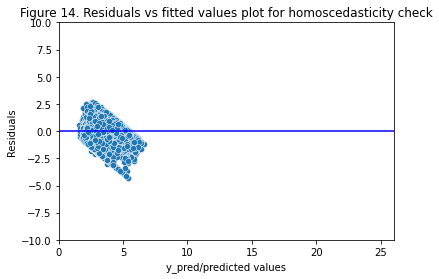

In [ ]:
p = sns.scatterplot(y_train_predict,ols_model_exout.resid)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Figure 14. Residuals vs fitted values plot for homoscedasticity check')

In [ ]:
import scipy.stats as stats
stat, p_value = stats.kstest(ols_model_exout.resid, 'norm')
print ('The z_score =', format(stat, '.2f')) #format printing of a floating point number
print('The p_value =', format(p_value, '.6f'))
if p_value >= 0.05:
  print('Data is normally distributed')
elif p_value < .05:
  print('Data is not normally distributed', '')

The z_score = 0.13
The p_value = 0.000000
Data is not normally distributed 


##**SARIMAX Model**

The model we are building to compare with our naive models is the SARIMA(p,d,q)(P,D,Q,S) model

S stands for Seasonal, AR is auto-regression, I is just integrated, MA means moving average and X stands for exogenous (i.e. features other than the value itself).

source of code:https://github.com/MKB-Datalab/time-series-analysis-with-SARIMAX-and-Prophet/blob/master/notebooks/02-Forecasting_with_SARIMAX.ipynb

In [ ]:
df_year = df.groupby(['date'], as_index=True).agg({'PM2.5':'mean'})
df_year

,PM2.5
date,
2013-03-01,7.326389
2013-03-02,31.475694
2013-03-03,79.291667
2013-03-04,22.309028
2013-03-05,127.868056
...,...
2017-02-24,25.493056
2017-02-25,12.149306
2017-02-26,28.069444


**Stationary test**

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def obtain_adf_kpss_results(timeseries, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series

    Args:
        time_series (df): Dataframe of univariate time series
        max_d (int): Max value of how many times apply difference

    Return:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times
        differencing on a time-series.

    """

    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True

        stationary = adf_stationary & kpss_stationary

        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))

    # Construct DataFrame
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])

    return results_df

In [ ]:
obtain_adf_kpss_results(df_year,2)  #already stationary

,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,4.276143e-30,0.1,True,True,True
1,1,3.245735e-25,0.1,True,True,True


In [ ]:
#train = df_md1.loc[:'2016-08-31']['PM2.5']
#test = df_md1.loc['2016-08-31':]['PM2.5']
#exog_train = df_md1.drop(['PM2.5','station','year','PRES','TEMP','RAIN','month','day','hour','date','wd'], axis=1).loc[:'2016-08-31']
#exog_test = df_md1.drop(['PM2.5','station','year','PRES','TEMP','RAIN','month','day','hour','date','wd'], axis=1).loc['2016-08-31':]
train = df_year.loc[:'2016-08-31']
test = df_year.loc['2016-08-31':]

Text(0.5, 0, 'Train/Test Split for Yearly PM2.5')

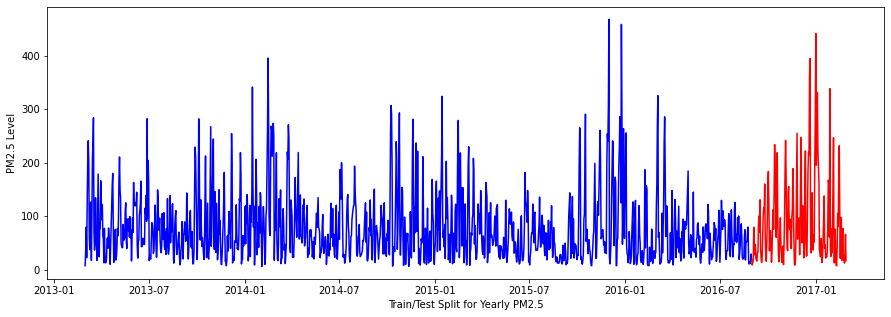

In [ ]:
plt.figure(figsize = (15,5))
plt.plot('PM2.5', data=train, color = 'blue')
plt.plot('PM2.5', data=test, color = 'red')
plt.ylabel('PM2.5 Level')
plt.xlabel('Train/Test Split for Yearly PM2.5')

fitting the ARIMA model for different values of p and q, and choosing the best value based on metrics such as AIC and BIC.

*   AIC (Akaike information criterion) is a metric which tells us how good a model is. Lower the value, better the model. The AIC also penalizes models which have lots of parameters. This means if we set the order too high compared to the data, we will get a high AIC value. This stops us overfitting to the training data.
*   BIC (Bayesian information criterion) is similar to AIC, therefore lower value means a better model. However, BIC penalizes additional model orders more than AIC. As consequence, BIC will sometimes suggest a simpler model.



In [ ]:
import itertools
#The models notation is SARIMA(p, d, q).(P,D,Q)m. These three parameters account
#for seasonality, trend, and noise in data
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(df_year,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
      results = mod.fit()
      print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
    except:
       continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:17681.192822564237
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:17163.043347323917
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:17157.888250369557
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:16150.274265730615
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:16853.174066670825
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:16304.148266041404
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:16583.54326768306
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:16147.62471801199
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:16646.93875516739
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:16333.218518397034
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:16658.092377918503
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:15596.16533348725
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:16225.493019618425
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:15744.834301417844
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:16080.625762753643
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:15597.892326833233
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:16143.421439234558
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:16004.006514752

In [ ]:
#Given a collection of models for the data, AIC estimates the quality of each model,
#relative to each of the other models. The low AIC value the better. Our output suggests
#that SARIMAX(1, 0, 1)x(0, 1, 1, 12) with AIC value of 15529.7 is the best combination,
#so we should consider this to be optimal option.
mod = sm.tsa.statespace.SARIMAX(df_year, order=(1, 0, 1),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,
          enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                 1461
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -7760.866
Date:                            Thu, 22 Dec 2022   AIC                          15529.732
Time:                                    22:44:38   BIC                          15550.807
Sample:                                03-01-2013   HQIC                         15537.601
                                     - 02-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3719      0.028     13.489      0.000       0.318       0.426
ma.L1          0.3056      0.034   

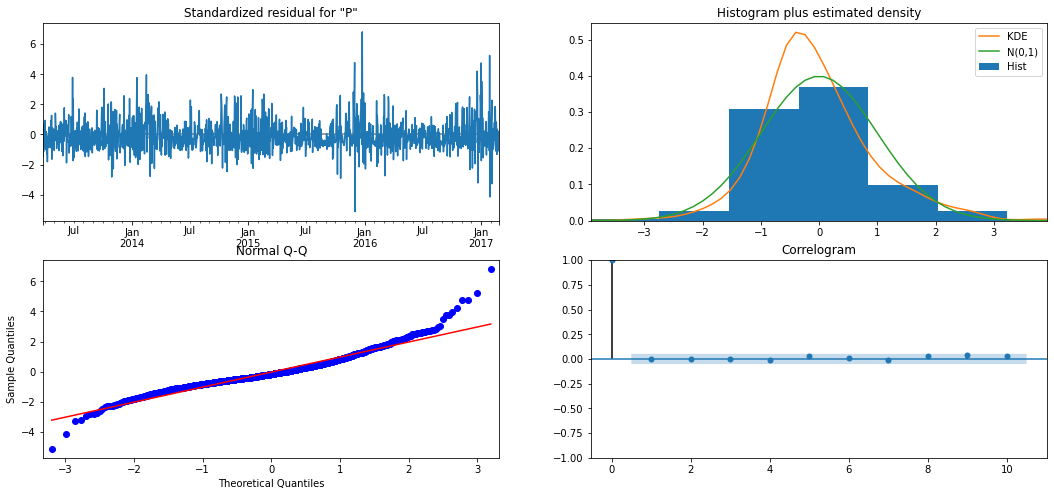

In [ ]:
#With the diagnostic below we can visualize important information
#as the distribution and the Auto correlation function ACF (correlogram).
#Values upward the “0” has some correlation over the time series data.
#Values near to “1” demonstrates strongest correlation.
results.plot_diagnostics(figsize=(18, 8))
plt.show()

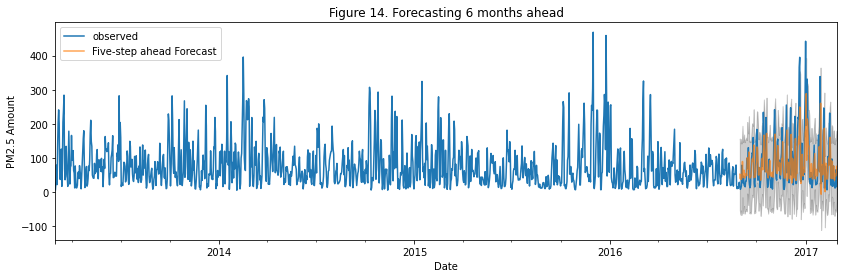

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2016-08-31'), steps=5, dynamic=False)
pred_ci = pred.conf_int()
ax = df_year['PM2.5'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Five-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5 Amount')
plt.legend()
plt.title('Figure 14. Forecasting 6 months ahead')
plt.show()

In [ ]:
mean_absolute_error(test,pred.predicted_mean)

47.99430151238812